## Grid Sapientino.

Level of abstraction "one", with restraining bolts.

The goal is to visit N colors in a certain order.

In [1]:
%matplotlib inline

import tempfile
from pathlib import Path
from multinav.algorithms.value_iteration import value_iteration
from multinav.envs.env_abstract_sapientino import AbstractSapientinoTemporalGoal
from multinav.envs.env_cont_sapientino import Fluents
from multinav.envs.env_grid_sapientino import generate_grid, GridSapientinoRewardShaper
from multinav.envs.temporal_goals import SapientinoGoal
from multinav.wrappers.sapientino import GridRobotFeatures
from multinav.wrappers.reward_shaping import RewardShapingWrapper
from multinav.wrappers.temprl import MyTemporalGoalWrapper
from multinav.wrappers.utils import MyStatsRecorder, SingleAgentWrapper
import numpy as np
from gym_sapientino.core.configurations import SapientinoConfiguration
from gym_sapientino.core.types import Colors
import matplotlib.pyplot as plt
from multinav.helpers.misc import plot_average_stats, Experiment

from gym.wrappers import TimeLimit
from multinav.algorithms.q_learning import q_learning
from gym_sapientino import SapientinoDictSpace
from multinav.helpers.gym import rollout
from multinav.helpers.notebooks import plot_env, display_img_array

pygame 2.0.1 (SDL 2.0.14, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


Before temporal goal wrapper:
Observation space: Dict(ang_velocity:Box(-40.0, 40.0, (1,), float32), angle:Box(0.0, 360.0, (1,), float32), beep:Discrete(2), color:Discrete(10), discrete_x:Discrete(9), discrete_y:Discrete(5), theta:Discrete(4), velocity:Box(-0.20000000298023224, 0.20000000298023224, (1,), float32), x:Box(0.0, 9.0, (1,), float32), y:Box(0.0, 5.0, (1,), float32))
Action space: Discrete(6)
After temporal goal wrapper:
Observation space: MultiDiscrete([9 5 5])
Action space: Discrete(6)


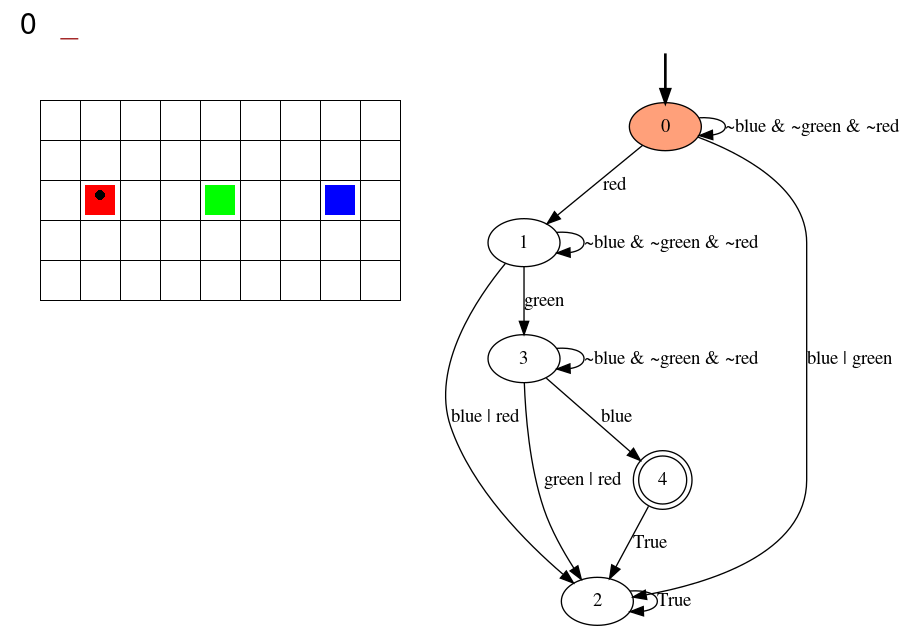

In [2]:
nb_colors = 3
temp_file = Path(tempfile.mktemp(suffix=".txt"))
generate_grid(nb_colors, temp_file)
configuration = SapientinoConfiguration(
    path_to_map=temp_file,
    reward_per_step=-0.01,
    reward_outside_grid=0.0,
    reward_duplicate_beep=0.0,
)
env = SingleAgentWrapper(SapientinoDictSpace(configuration))
print("Before temporal goal wrapper:")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

tg = SapientinoGoal(
    colors=["red", "green", "blue"],
    fluents=Fluents(colors_set={str(c) for c in Colors}),
    reward=10.0,
)
env = GridRobotFeatures(MyTemporalGoalWrapper(env, [tg]))
print("After temporal goal wrapper:")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

display_img_array(env.render(mode="rgb_array"))

## Q-Learning

In the next, we use Q-Learning for training the agent with the restraining bolt.

In [3]:
env = MyStatsRecorder(TimeLimit(env, max_episode_steps=25))
Q = q_learning(env, total_timesteps=75000)

episode_rewards = env.episode_rewards
episode_lengths = env.episode_lengths

# plot
plt.title("Episode lengths")
plt.plot(episode_lengths)
plt.show()

plt.title("Episode Rewards")
plt.plot(episode_rewards)
plt.show()


KeyboardInterrupt: 

In [ ]:

rollout(env, policy=lambda _env, state: np.argmax(Q[state]), callback=plot_env)

Averages of several runs. The setups are:
1. `q-learning`: no reward shaping
1. `q-learning-neg`: no reward shaping, and small negative step-reward
3. `q-learning-rs`: reward shaping from previous layer, and small negative step-reward


In [ ]:
nb_colors = 3
nb_runs = 64
nb_processes = 8

# for convenience, we run value iteration only once.
env = AbstractSapientinoTemporalGoal(nb_colors=nb_colors, failure_probability=0.1)
value, policy = value_iteration(env, discount=0.9, max_iterations=200)


def run_experiment(
    nb_colors = 3,
    nb_runs=32,
    nb_processes=8,
    reward_per_step=0.0,
    reward_outside_grid=0.0,
    reward_duplicate_beep=0.0,
    nb_episodes=3000,
    alpha=0.1,
    eps=0.1,
    gamma=0.9,
    learning_rate_decay=False,
    epsilon_decay=False,
    value_function=None
):
    """Run a full experiment."""
    temp_file = Path(tempfile.mktemp(suffix=".txt"))
    generate_grid(nb_colors, temp_file)
    configuration = SapientinoConfiguration(
        path_to_map=temp_file,
        reward_per_step=reward_per_step,
        reward_outside_grid=reward_outside_grid,
        reward_duplicate_beep=reward_duplicate_beep,
    )
    env = SingleAgentWrapper(SapientinoDictSpace(configuration))
    tg = SapientinoGoal(
        colors=["red", "green", "blue"],
        fluents=Fluents(colors_set={str(c) for c in Colors}),
        reward=10.0,
    )
    env = MyTemporalGoalWrapper(env, [tg])
    env = MyStatsRecorder(TimeLimit(env, max_episode_steps=30))
    if value_function is not None:
        reward_shaper = GridSapientinoRewardShaper(value_function, gamma)
        env = RewardShapingWrapper(env, reward_shaper)
    env = GridRobotFeatures(env)
    env = MyStatsRecorder(env, prefix="rs_")
    seeds = list(range(nb_runs))
    qlearning_params = dict(
        nb_episodes=nb_episodes,
        alpha=alpha,
        eps=eps,
        gamma=gamma,
        learning_rate_decay=learning_rate_decay,
        epsilon_decay=epsilon_decay,
    )

    experiment = Experiment(
        env, q_learning, qlearning_params, nb_runs=nb_runs,
        nb_processes=nb_processes, seeds=seeds
    )

    stats = experiment.run()
    return stats


stats_1 = run_experiment(nb_runs=nb_runs)
stats_2 = run_experiment(nb_runs=nb_runs, reward_per_step=-0.01)
stats_3 = run_experiment(nb_runs=nb_runs, nb_colors=nb_colors, reward_per_step=-0.01, value_function=value)

plot_average_stats([stats_1, stats_2, stats_3], ["q-learning", "q-learning-neg", "q-learning-rs"])

Results: reward shaping is beneficial for learning.
